[*********************100%%**********************]  1 of 1 completed
Epoch 1/10
165/165 [==============================] - 19s 56ms/step - loss: 1.6740e-04 - val_loss: 2.6060e-04
Epoch 2/10
165/165 [==============================] - 8s 51ms/step - loss: 2.7394e-05 - val_loss: 4.6286e-04
Epoch 3/10
165/165 [==============================] - 4s 23ms/step - loss: 2.0777e-05 - val_loss: 3.3730e-04
Epoch 4/10
165/165 [==============================] - 5s 32ms/step - loss: 2.0104e-05 - val_loss: 2.2871e-04
Epoch 5/10
165/165 [==============================] - 4s 22ms/step - loss: 2.1173e-05 - val_loss: 3.2147e-04
Epoch 6/10
165/165 [==============================] - 4s 24ms/step - loss: 2.3630e-05 - val_loss: 1.5586e-04
Epoch 7/10
165/165 [==============================] - 5s 33ms/step - loss: 1.7777e-05 - val_loss: 1.5716e-04
Epoch 8/10
165/165 [==============================] - 4s 23ms/step - loss: 2.3179e-05 - val_loss: 1.5239e-04
Epoch 9/10
165/165 [==============================] - 4s 2

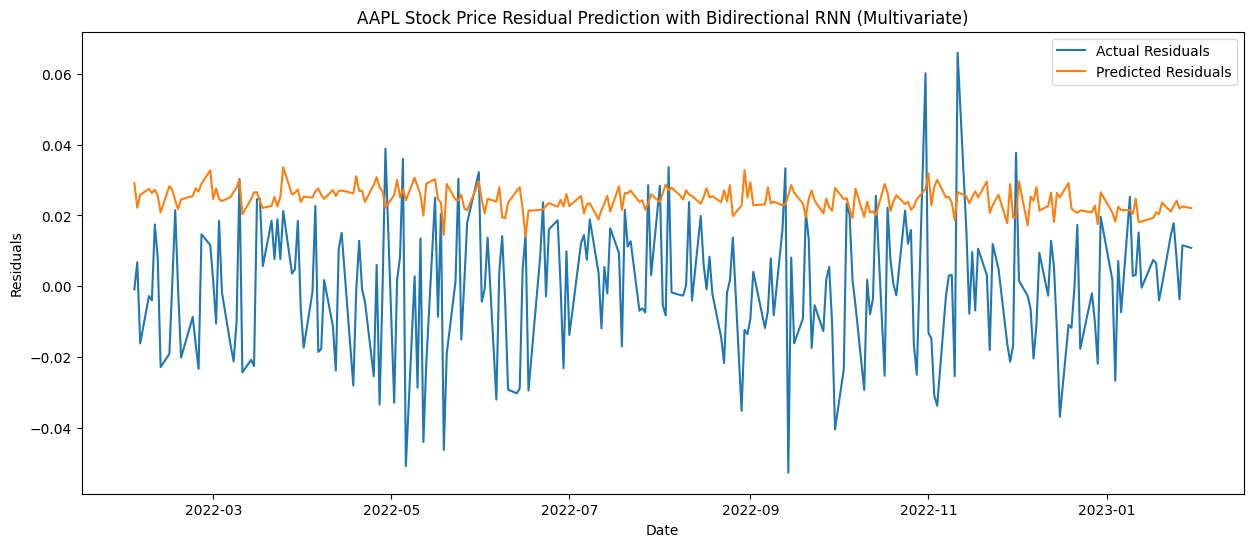

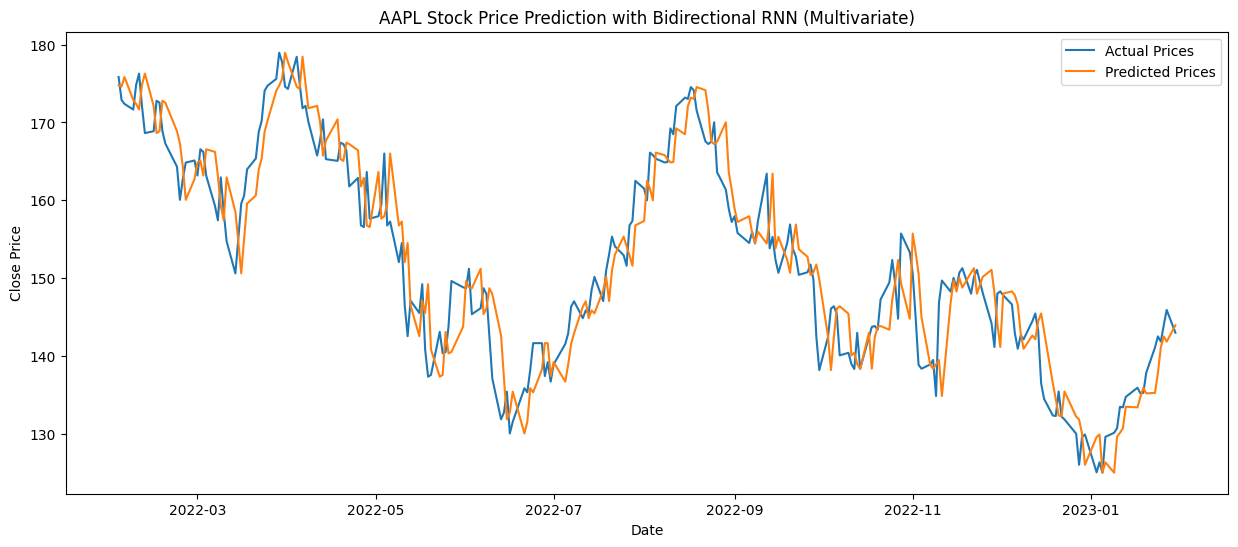

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Bidirectional, SimpleRNN, Dense
from scipy.stats import pearsonr  # 添加导入语句

# 下载数据
aapl_df_yf = yf.download(tickers="AAPL", start='2000-01-01', end='2023-01-31')

# 选择需要的特征
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = aapl_df_yf[features]

# 将数据缩放到0到1的范围
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 划分训练、验证和测试集
train_end_date = '2020-12-31'
valid_end_date = '2022-01-01'  # 添加验证集结束日期
train_size = len(data[data.index <= train_end_date])
valid_size = len(data[(data.index > train_end_date) & (data.index <= valid_end_date)])
train_data, valid_data, test_data = (
    data_scaled[0:train_size, :],
    data_scaled[train_size:train_size + valid_size, :],
    data_scaled[train_size + valid_size :, :],
)

# 创建X和y的数据集，X为过去的时间步，y为当前时间步
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps - 1):
        a = dataset[i : (i + time_steps), :]
        # 计算残差（差异）
        residual = dataset[i + time_steps, 3] - dataset[i + time_steps - 1, 3]
        dataX.append(a)
        dataY.append(residual)
    return np.array(dataX), np.array(dataY)

time_steps = 20  # 过去的时间步
X_train, y_train = create_dataset(train_data, time_steps)
X_valid, y_valid = create_dataset(valid_data, time_steps)  # 添加验证集的创建
X_test, y_test = create_dataset(test_data, time_steps)

# 构建Bidirectional RNN模型
model = Sequential()
model.add(Bidirectional(SimpleRNN(50, activation='relu'), input_shape=(time_steps, len(features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型，包含验证集
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    verbose=1,
    validation_data=(X_valid, y_valid),  # 添加验证集
)

# 在测试集上进行预测
y_pred_residual = model.predict(X_test)

# 累积预测的残差以获得最终的预测价格
y_pred_cumsum = np.cumsum(y_pred_residual)
y_pred_unscaled = scaler.inverse_transform(np.hstack((X_test[:, -1, 0:4], y_pred_cumsum.reshape(-1, 1))))

# 计算均方根误差
rmse = np.sqrt(mean_squared_error(y_test, y_pred_residual))
print(f'Root Mean Squared Error (RMSE) of Residuals: {rmse}')

# 计算Pearson相关系数
pearson_corr, _ = pearsonr(y_test.flatten(), y_pred_residual.flatten())
print(f'Pearson Correlation Coefficient: {pearson_corr}')

# 绘制残差预测结果
plt.figure(figsize=(15, 6))
plt.plot(aapl_df_yf.index[train_size + valid_size + time_steps + 1 :], y_test, label='Actual Residuals')
plt.plot(aapl_df_yf.index[train_size + valid_size + time_steps + 1 :], y_pred_residual, label='Predicted Residuals')
plt.title('AAPL Stock Price Residual Prediction with Bidirectional RNN (Multivariate)')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# 绘制最终的股票收盘价预测结果
plt.figure(figsize=(15, 6))
plt.plot(
    aapl_df_yf.index[train_size + valid_size + time_steps + 1 :],
    aapl_df_yf['Close'][train_size + valid_size + time_steps + 1 :],
    label='Actual Prices',
)
plt.plot(
    aapl_df_yf.index[train_size + valid_size + time_steps + 1 :],
    y_pred_unscaled[:, 3],
    label='Predicted Prices',
)
plt.title('AAPL Stock Price Prediction with Bidirectional RNN (Multivariate)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed
Epoch 1/10
165/165 [==============================] - 3s 15ms/step - loss: 2.4544e-05 - val_loss: 1.4824e-04
Epoch 2/10
165/165 [==============================] - 2s 13ms/step - loss: 2.1483e-05 - val_loss: 1.7431e-04
Epoch 3/10
165/165 [==============================] - 3s 19ms/step - loss: 1.6387e-05 - val_loss: 1.9166e-04
Epoch 4/10
165/165 [==============================] - 4s 27ms/step - loss: 1.7709e-05 - val_loss: 3.8088e-04
Epoch 5/10
165/165 [==============================] - 2s 14ms/step - loss: 2.0035e-05 - val_loss: 2.0649e-04
Epoch 6/10
165/165 [==============================] - 3s 17ms/step - loss: 1.8159e-05 - val_loss: 2.8912e-04
Epoch 7/10
165/165 [==============================] - 5s 33ms/step - loss: 1.6526e-05 - val_loss: 2.4714e-04
Epoch 8/10
165/165 [==============================] - 2s 15ms/step - loss: 1.8705e-05 - val_loss: 1.8244e-04
Epoch 9/10
165/165 [==============================] - 2s 13

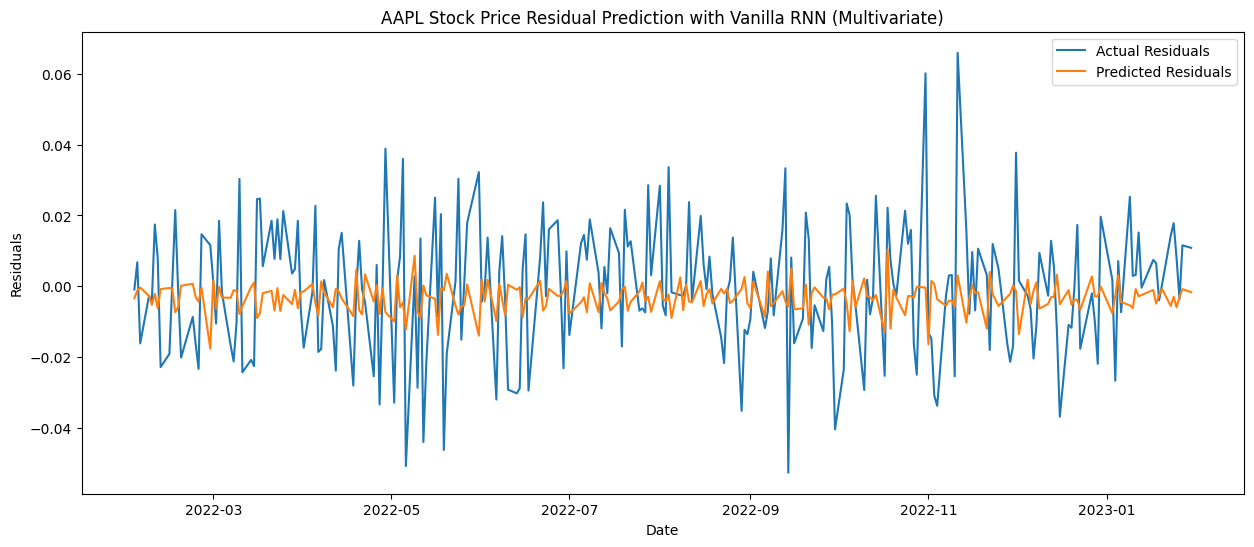

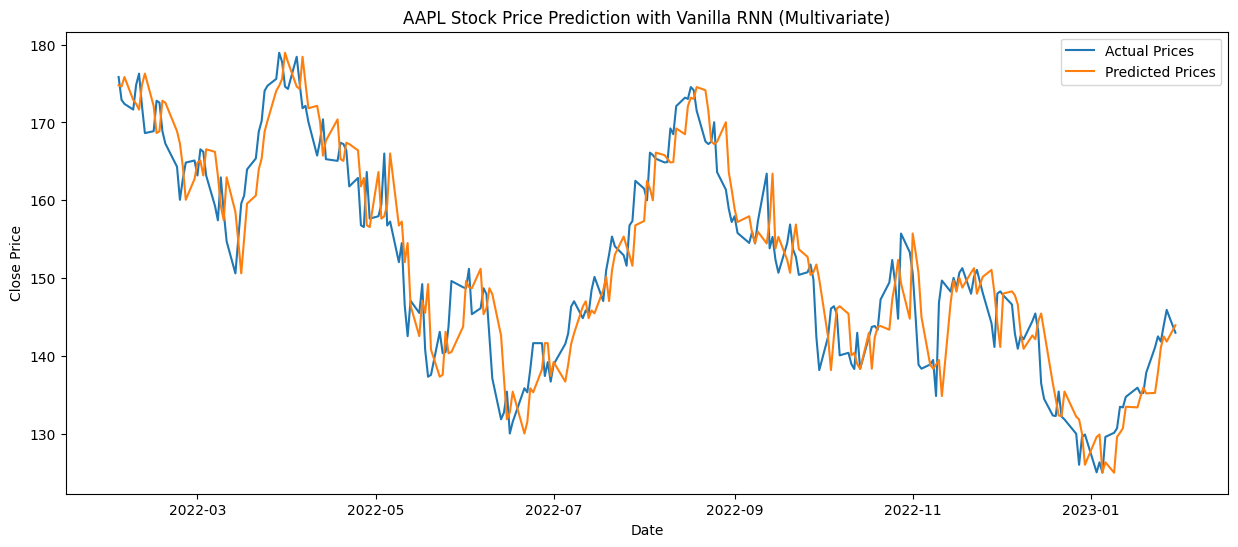

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from scipy.stats import pearsonr

# 下载数据
aapl_df_yf = yf.download(tickers="AAPL", start='2000-01-01', end='2023-01-31')

# 选择需要的特征
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = aapl_df_yf[features]

# 将数据缩放到0到1的范围
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 划分训练、验证和测试集
train_end_date = '2020-12-31'
valid_end_date = '2022-01-01'
train_size = len(data[data.index <= train_end_date])
valid_size = len(data[(data.index > train_end_date) & (data.index <= valid_end_date)])
train_data, valid_data, test_data = (
    data_scaled[0:train_size, :],
    data_scaled[train_size:train_size + valid_size, :],
    data_scaled[train_size + valid_size :, :],
)

# 创建X和y的数据集，X为过去的时间步，y为当前时间步
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps - 1):
        a = dataset[i : (i + time_steps), :]
        # 计算残差（差异）
        residual = dataset[i + time_steps, 3] - dataset[i + time_steps - 1, 3]
        dataX.append(a)
        dataY.append(residual)
    return np.array(dataX), np.array(dataY)

time_steps = 20
X_train, y_train = create_dataset(train_data, time_steps)
X_valid, y_valid = create_dataset(valid_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# 构建Vanilla RNN模型
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(time_steps, len(features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型，包含验证集
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    verbose=1,
    validation_data=(X_valid, y_valid),
)

# 在测试集上进行预测
y_pred_residual = model.predict(X_test)

# 累积预测的残差以获得最终的预测价格
y_pred_cumsum = np.cumsum(y_pred_residual)
y_pred_unscaled = scaler.inverse_transform(np.hstack((X_test[:, -1, 0:4], y_pred_cumsum.reshape(-1, 1))))

# 计算均方根误差
rmse = np.sqrt(mean_squared_error(y_test, y_pred_residual))
print(f'Root Mean Squared Error (RMSE) of Residuals: {rmse}')

# 计算Pearson相关系数
pearson_corr, _ = pearsonr(y_test.flatten(), y_pred_residual.flatten())
print(f'Pearson Correlation Coefficient: {pearson_corr}')

# 绘制残差预测结果
plt.figure(figsize=(15, 6))
plt.plot(aapl_df_yf.index[train_size + valid_size + time_steps + 1 :], y_test, label='Actual Residuals')
plt.plot(aapl_df_yf.index[train_size + valid_size + time_steps + 1 :], y_pred_residual, label='Predicted Residuals')
plt.title('AAPL Stock Price Residual Prediction with Vanilla RNN (Multivariate)')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# 绘制最终的股票收盘价预测结果
plt.figure(figsize=(15, 6))
plt.plot(
    aapl_df_yf.index[train_size + valid_size + time_steps + 1 :],
    aapl_df_yf['Close'][train_size + valid_size + time_steps + 1 :],
    label='Actual Prices',
)
plt.plot(
    aapl_df_yf.index[train_size + valid_size + time_steps + 1 :],
    y_pred_unscaled[:, 3],
    label='Predicted Prices',
)
plt.title('AAPL Stock Price Prediction with Vanilla RNN (Multivariate)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
165/165 [==============================] - 7s 32ms/step - loss: 2.6476e-05 - val_loss: 2.3186e-04
Epoch 2/10
165/165 [==============================] - 7s 41ms/step - loss: 1.7963e-05 - val_loss: 1.4187e-04
Epoch 3/10
165/165 [==============================] - 5s 30ms/step - loss: 2.0448e-05 - val_loss: 1.4068e-04
Epoch 4/10
165/165 [==============================] - 6s 38ms/step - loss: 1.6011e-05 - val_loss: 1.4166e-04
Epoch 5/10
165/165 [==============================] - 5s 31ms/step - loss: 1.7999e-05 - val_loss: 1.6278e-04
Epoch 6/10
165/165 [==============================] - 5s 31ms/step - loss: 1.7207e-05 - val_loss: 1.5690e-04
Epoch 7/10
165/165 [==============================] - 7s 41ms/step - loss: 1.5907e-05 - val_loss: 1.4810e-04
Epoch 8/10
165/165 [==============================] - 5s 29ms/step - loss: 1.6033e-05 - val_loss: 5.2040e-04
Epoch 9/10
165/165 [==============================] - 7s 41ms/step - loss: 1.8617e-05 - val_loss: 1.3660e-04
Epoch 10/10
8/8 [=

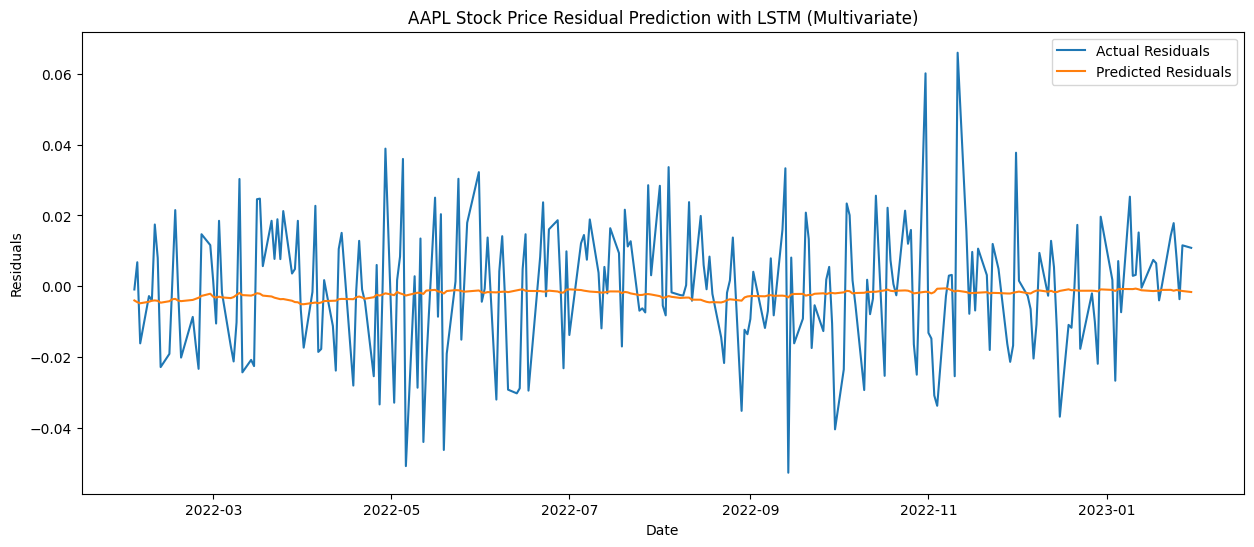

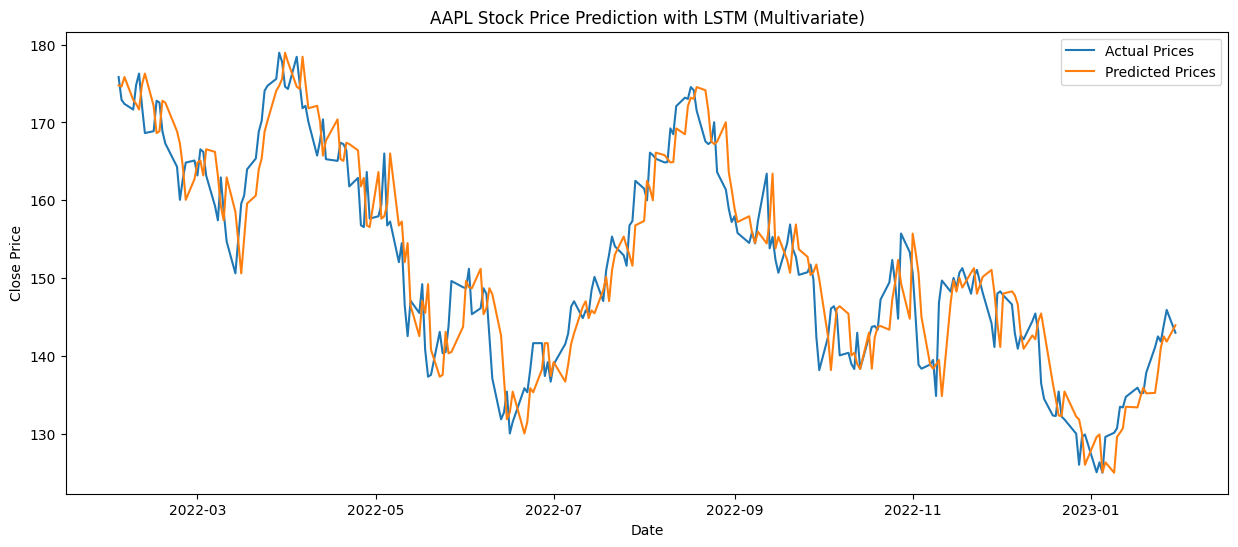

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from scipy.stats import pearsonr

# 下载数据
aapl_df_yf = yf.download(tickers="AAPL", start='2000-01-01', end='2023-01-31')

# 选择需要的特征
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = aapl_df_yf[features]

# 将数据缩放到0到1的范围
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 划分训练、验证和测试集
train_end_date = '2020-12-31'
valid_end_date = '2022-01-01'
train_size = len(data[data.index <= train_end_date])
valid_size = len(data[(data.index > train_end_date) & (data.index <= valid_end_date)])
train_data, valid_data, test_data = (
    data_scaled[0:train_size, :],
    data_scaled[train_size:train_size + valid_size, :],
    data_scaled[train_size + valid_size :, :],
)

# 创建X和y的数据集，X为过去的时间步，y为当前时间步
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps - 1):
        a = dataset[i : (i + time_steps), :]
        # 计算残差（差异）
        residual = dataset[i + time_steps, 3] - dataset[i + time_steps - 1, 3]
        dataX.append(a)
        dataY.append(residual)
    return np.array(dataX), np.array(dataY)

time_steps = 20
X_train, y_train = create_dataset(train_data, time_steps)
X_valid, y_valid = create_dataset(valid_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# 构建LSTM模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, len(features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型，包含验证集
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    verbose=1,
    validation_data=(X_valid, y_valid),
)

# 在测试集上进行预测
y_pred_residual = model.predict(X_test)

# 累积预测的残差以获得最终的预测价格
y_pred_cumsum = np.cumsum(y_pred_residual)
y_pred_unscaled = scaler.inverse_transform(np.hstack((X_test[:, -1, 0:4], y_pred_cumsum.reshape(-1, 1))))

# 计算均方根误差
rmse = np.sqrt(mean_squared_error(y_test, y_pred_residual))
print(f'Root Mean Squared Error (RMSE) of Residuals: {rmse}')

# 计算Pearson相关系数
pearson_corr, _ = pearsonr(y_test.flatten(), y_pred_residual.flatten())
print(f'Pearson Correlation Coefficient: {pearson_corr}')

# 绘制残差预测结果
plt.figure(figsize=(15, 6))
plt.plot(aapl_df_yf.index[train_size + valid_size + time_steps + 1 :], y_test, label='Actual Residuals')
plt.plot(aapl_df_yf.index[train_size + valid_size + time_steps + 1 :], y_pred_residual, label='Predicted Residuals')
plt.title('AAPL Stock Price Residual Prediction with LSTM (Multivariate)')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# 绘制最终的股票收盘价预测结果
plt.figure(figsize=(15, 6))
plt.plot(
    aapl_df_yf.index[train_size + valid_size + time_steps + 1 :],
    aapl_df_yf['Close'][train_size + valid_size + time_steps + 1 :],
    label='Actual Prices',
)
plt.plot(
    aapl_df_yf.index[train_size + valid_size + time_steps + 1 :],
    y_pred_unscaled[:, 3],
    label='Predicted Prices',
)
plt.title('AAPL Stock Price Prediction with LSTM (Multivariate)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
165/165 [==============================] - 9s 37ms/step - loss: 8.7064e-05 - val_loss: 1.3787e-04
Epoch 2/10
165/165 [==============================] - 8s 49ms/step - loss: 1.6664e-05 - val_loss: 1.5786e-04
Epoch 3/10
165/165 [==============================] - 6s 38ms/step - loss: 1.6142e-05 - val_loss: 2.4826e-04
Epoch 4/10
165/165 [==============================] - 9s 52ms/step - loss: 1.5930e-05 - val_loss: 1.9303e-04
Epoch 5/10
165/165 [==============================] - 6s 37ms/step - loss: 1.6389e-05 - val_loss: 4.4053e-04
Epoch 6/10
165/165 [==============================] - 8s 48ms/step - loss: 1.7162e-05 - val_loss: 1.3686e-04
Epoch 7/10
165/165 [==============================] - 6s 37ms/step - loss: 1.5129e-05 - val_loss: 1.5294e-04
Epoch 8/10
165/165 [==============================] - 8s 48ms/step - loss: 1.7064e-05 - val_loss: 1.4144e-04
Epoch 9/10
165/165 [==============================] - 6s 37ms/step - loss: 1.6381e-05 - val_loss: 1.4167e-04
Epoch 10/10
8/8 [=

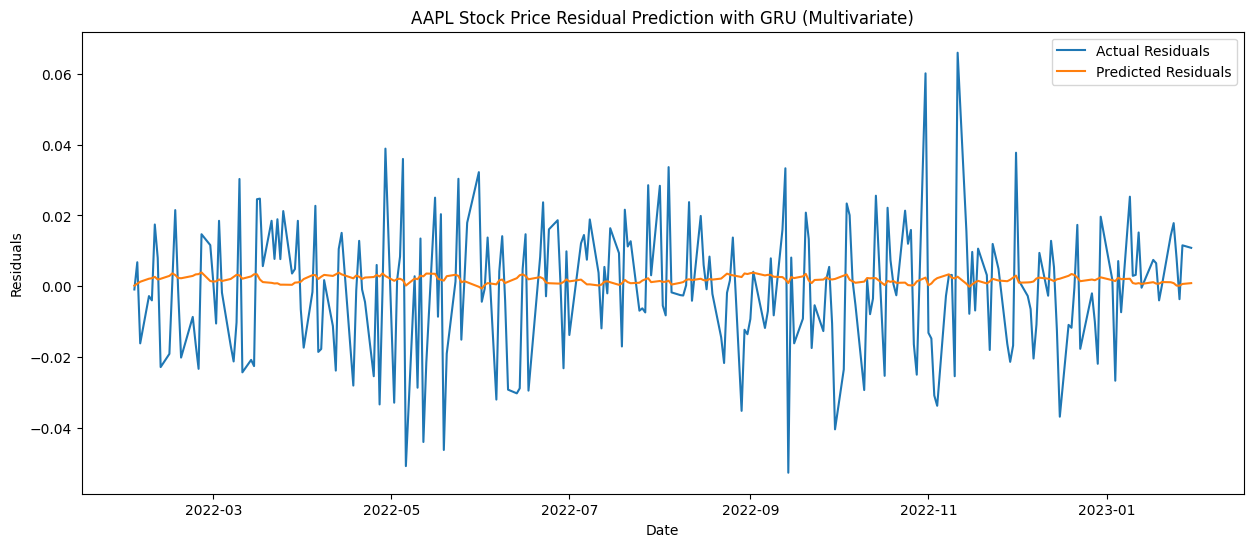

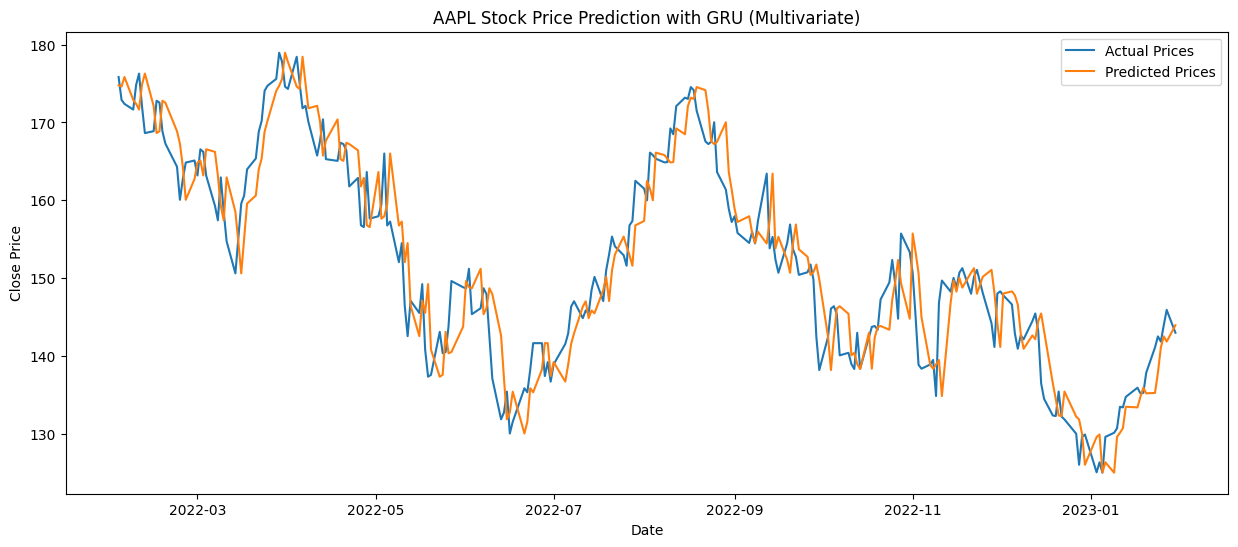

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import GRU, Dense
from scipy.stats import pearsonr

# 下载数据
aapl_df_yf = yf.download(tickers="AAPL", start='2000-01-01', end='2023-01-31')

# 选择需要的特征
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = aapl_df_yf[features]

# 将数据缩放到0到1的范围
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 划分训练、验证和测试集
train_end_date = '2020-12-31'
valid_end_date = '2022-01-01'
train_size = len(data[data.index <= train_end_date])
valid_size = len(data[(data.index > train_end_date) & (data.index <= valid_end_date)])
train_data, valid_data, test_data = (
    data_scaled[0:train_size, :],
    data_scaled[train_size:train_size + valid_size, :],
    data_scaled[train_size + valid_size :, :],
)

# 创建X和y的数据集，X为过去的时间步，y为当前时间步
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps - 1):
        a = dataset[i : (i + time_steps), :]
        # 计算残差（差异）
        residual = dataset[i + time_steps, 3] - dataset[i + time_steps - 1, 3]
        dataX.append(a)
        dataY.append(residual)
    return np.array(dataX), np.array(dataY)

time_steps = 20
X_train, y_train = create_dataset(train_data, time_steps)
X_valid, y_valid = create_dataset(valid_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# 构建GRU模型
model = Sequential()
model.add(GRU(50, activation='relu', input_shape=(time_steps, len(features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型，包含验证集
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    verbose=1,
    validation_data=(X_valid, y_valid),
)

# 在测试集上进行预测
y_pred_residual = model.predict(X_test)

# 累积预测的残差以获得最终的预测价格
y_pred_cumsum = np.cumsum(y_pred_residual)
y_pred_unscaled = scaler.inverse_transform(np.hstack((X_test[:, -1, 0:4], y_pred_cumsum.reshape(-1, 1))))

# 计算均方根误差
rmse = np.sqrt(mean_squared_error(y_test, y_pred_residual))
print(f'Root Mean Squared Error (RMSE) of Residuals: {rmse}')

# 计算Pearson相关系数
pearson_corr, _ = pearsonr(y_test.flatten(), y_pred_residual.flatten())
print(f'Pearson Correlation Coefficient: {pearson_corr}')

# 绘制残差预测结果
plt.figure(figsize=(15, 6))
plt.plot(aapl_df_yf.index[train_size + valid_size + time_steps + 1 :], y_test, label='Actual Residuals')
plt.plot(aapl_df_yf.index[train_size + valid_size + time_steps + 1 :], y_pred_residual, label='Predicted Residuals')
plt.title('AAPL Stock Price Residual Prediction with GRU (Multivariate)')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# 绘制最终的股票收盘价预测结果
plt.figure(figsize=(15, 6))
plt.plot(
    aapl_df_yf.index[train_size + valid_size + time_steps + 1 :],
    aapl_df_yf['Close'][train_size + valid_size + time_steps + 1 :],
    label='Actual Prices',
)
plt.plot(
    aapl_df_yf.index[train_size + valid_size + time_steps + 1 :],
    y_pred_unscaled[:, 3],
    label='Predicted Prices',
)
plt.title('AAPL Stock Price Prediction with GRU (Multivariate)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
